*  Nama : Rizky Adhi Nugroho
*  domisili : Tangerang Selatan 
*  email   : nugrohorizkyadhi@gmail.com 

import data stock dari kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizkyadhiiii","key":"8ad012eb3b08719fd1db8a4ac7618a95"}'}

In [ ]:
#download dari kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 100MB/s]


In [ ]:
#ekstrak file
!unzip /content/stock-time-series-20050101-to-20171231.zip

Archive:  /content/stock-time-series-20050101-to-20171231.zip
  inflating: AABA_2006-01-01_to_2018-01-01.csv  
  inflating: AAPL_2006-01-01_to_2018-01-01.csv  
  inflating: AMZN_2006-01-01_to_2018-01-01.csv  
  inflating: AXP_2006-01-01_to_2018-01-01.csv  
  inflating: BA_2006-01-01_to_2018-01-01.csv  
  inflating: CAT_2006-01-01_to_2018-01-01.csv  
  inflating: CSCO_2006-01-01_to_2018-01-01.csv  
  inflating: CVX_2006-01-01_to_2018-01-01.csv  
  inflating: DIS_2006-01-01_to_2018-01-01.csv  
  inflating: GE_2006-01-01_to_2018-01-01.csv  
  inflating: GOOGL_2006-01-01_to_2018-01-01.csv  
  inflating: GS_2006-01-01_to_2018-01-01.csv  
  inflating: HD_2006-01-01_to_2018-01-01.csv  
  inflating: IBM_2006-01-01_to_2018-01-01.csv  
  inflating: INTC_2006-01-01_to_2018-01-01.csv  
  inflating: JNJ_2006-01-01_to_2018-01-01.csv  
  inflating: JPM_2006-01-01_to_2018-01-01.csv  
  inflating: KO_2006-01-01_to_2018-01-01.csv  
  inflating: MCD_2006-01-01_to_2018-01-01.csv  
  inflating: MMM_2006-01

import librarry

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

buat dataframe

In [ ]:
df = pd.read_csv('/content/AABA_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])
print(df.info())
print(df.tail())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3019 non-null   datetime64[ns]
 1   Open    3019 non-null   float64       
 2   High    3019 non-null   float64       
 3   Low     3019 non-null   float64       
 4   Close   3019 non-null   float64       
 5   Volume  3019 non-null   int64         
 6   Name    3019 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.2+ KB
None
           Date   Open   High    Low  Close    Volume  Name
3014 2017-12-22  71.42  71.87  71.22  71.58  10979165  AABA
3015 2017-12-26  70.94  71.39  69.63  69.86   8542802  AABA
3016 2017-12-27  69.77  70.49  69.69  70.06   6345124  AABA
3017 2017-12-28  70.12  70.32  69.51  69.82   7556877  AABA
3018 2017-12-29  69.79  70.13  69.43  69.85   6613070  AABA
Date      0
Open      0
High      0
Low       0
Cl

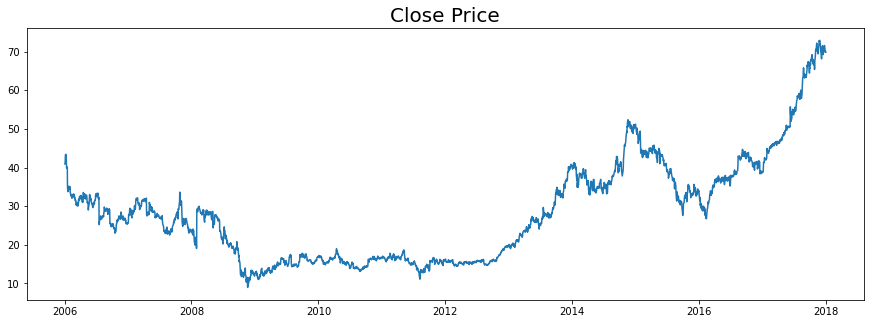

In [ ]:
#visualisasi data 
date = df['Date'].values
price  = df['Close'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(date, price)
plt.title('Close Price',
          fontsize=20);

split data 80 20

In [ ]:
from sklearn.model_selection import train_test_split
price_train, price_test, date_train, date_test = train_test_split(price, date, test_size=0.2, random_state=0, shuffle=False)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

membuat arsitektur model

In [ ]:
train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(price_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True), #menggunakan lstm.
  tf.keras.layers.Bidirectional(LSTM(60)), #menggunakan bidirectional lstm.
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9) #menggunakan Learning rate.
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

membuat callback

In [ ]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<3 and logs.get('val_mae')<3):
      print("\n mae dan val_mae dibawah 3!")
      self.model.stop_training = True
callbacks = myCallback()

10% dari skala pada data

In [ ]:
print('min price',price.min()) 
print('max price',price.max()) 
print('10% skala: ', (price.max()-price.min())*0.1) 

min price 8.95
max price 72.93
10% skala:  6.398000000000001


melatih model

In [ ]:
history = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
24/24 [==============================] - 11s 215ms/step - loss: 23.5868 - mae: 24.0868 - val_loss: 45.3661 - val_mae: 45.8661
Epoch 2/100
24/24 [==============================] - 4s 172ms/step - loss: 23.4130 - mae: 23.9130 - val_loss: 45.2373 - val_mae: 45.7373
Epoch 3/100
24/24 [==============================] - 4s 170ms/step - loss: 23.2722 - mae: 23.7722 - val_loss: 45.1168 - val_mae: 45.6168
Epoch 4/100
24/24 [==============================] - 4s 170ms/step - loss: 23.1370 - mae: 23.6370 - val_loss: 44.9619 - val_mae: 45.4619
Epoch 5/100
24/24 [==============================] - 4s 170ms/step - loss: 22.9762 - mae: 23.4762 - val_loss: 44.7757 - val_mae: 45.2757
Epoch 6/100
24/24 [==============================] - 4s 171ms/step - loss: 22.7839 - mae: 23.2839 - val_loss: 44.5506 - val_mae: 45.0506
Epoch 7/100
24/24 [==============================] - 4s 172ms/step - loss: 22.5479 - mae: 23.0479 - val_loss: 44.2793 - val_mae: 44.7793
Epoch 8/100
24/24 [=====================

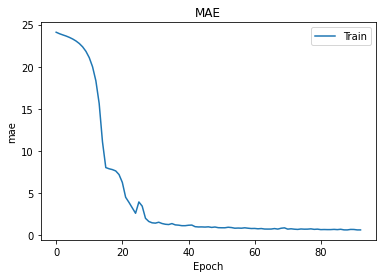

In [ ]:
plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

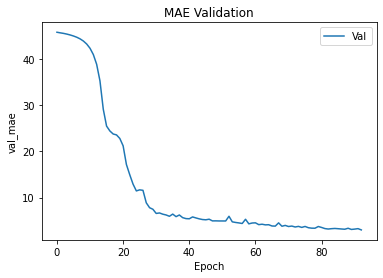

In [ ]:
plt.plot(history.history['val_mae'])
plt.title('MAE Validation')
plt.ylabel('val_mae')
plt.xlabel('Epoch')
plt.legend(['Val'], loc='upper right')
plt.show()